In [1]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
from tqdm import tqdm

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from tqdm import tqdm_notebook
import seaborn as sns
import imageio
import time
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs
import numpy as np

In [2]:
my_cmap = colors.LinearSegmentedColormap.from_list(" ", ['red','yellow', 'green'])

In [3]:
np.random.seed(0)

In [4]:
data, labels = make_blobs(n_samples = 1000, centers = 4, n_features = 2, random_state = 0)
print(data.shape, labels.shape)

(1000, 2) (1000,)


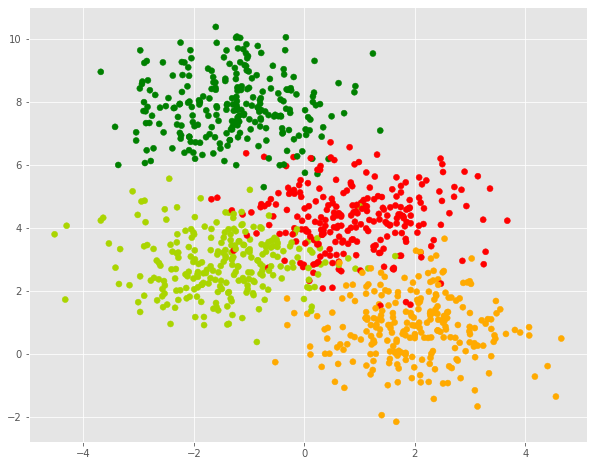

In [5]:
plt.figure(figsize = (10,8))
plt.style.use('ggplot')
plt.scatter(data[:,0], data[:, 1], c = labels, cmap = my_cmap)
plt.show()

In [6]:
labels_orig = labels
labels = np.mod(labels_orig, 2)

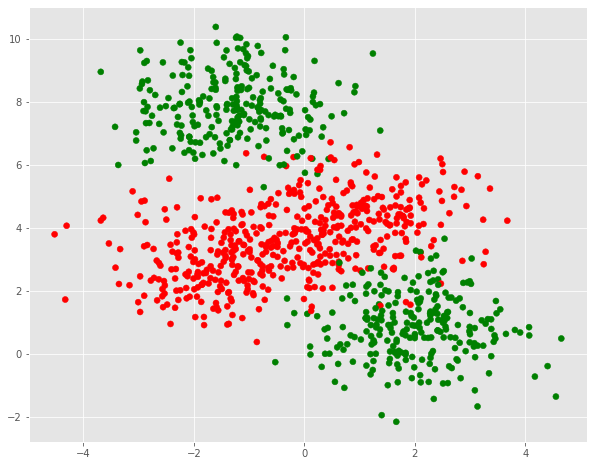

In [7]:
plt.figure(figsize = (10,8))
plt.style.use('ggplot')
plt.scatter(data[:,0], data[:, 1], c = labels, cmap = my_cmap)
plt.show()

In [8]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels_orig, stratify = labels_orig, random_state = 0)
print(X_train.shape, X_val.shape, labels_orig.shape)

(750, 2) (250, 2) (1000,)


In [9]:
enc = OneHotEncoder()
y_OH_train = enc.fit_transform(np.expand_dims(Y_train, 1)).toarray()
y_OH_test = enc.fit_transform(np.expand_dims(Y_train, 1)).toarray()
#print(y_OH_train)

In [10]:
W1 = np.random.randn(2, 2)
W2 = np.random.randn(2, 4)
print(W1)
print(W2)

[[1.76405235 0.40015721]
 [0.97873798 2.2408932 ]]
[[ 1.86755799 -0.97727788  0.95008842 -0.15135721]
 [-0.10321885  0.4105985   0.14404357  1.45427351]]


In [11]:

class FeedForwardNetwork:
    
    def __init__(self, W1, W2):
        self.params = {}
        self.params['W1'] = W1.copy()
        self.params['W2'] = W2.copy()
        self.params['B1'] = np.zeros((1, 2))
        self.params['B2'] = np.zeros((1, 4))
        self.num_layers = 2
        self.gradients = {}
        self.update_params = {}
        self.prev_update_params = {}
        for i in range(1, self.num_layers+1):
            self.update_params['v_w'+str(i)] = 0
            self.update_params['v_b'+str(i)] = 0
            self.update_params['m_w'+str(i)] = 0
            self.update_params['m_b'+str(i)] = 0
            #print("erew")
            self.prev_update_params['v_w'+str(i)] = 0
            self.prev_update_params['v_b'+str(i)] = 0
            
            
    def forward_activation(self, X):
        return 1. / (1. + np.exp(-X))
    
    def grad_activation(self, X):
        return X * (1-X)
    
    def softmax(self, X):
        exps = np.exp(X)
        return exps / np.sum(exps, axis = 1).reshape(-1, 1)
    
    def forward_pass(self, X, params = None):
        if params is None:
            params = self.params
        self.A1 = np.matmul(X, params['W1']) + params['B1']
        self.H1 = self.forward_activation(self.A1)
        self.A2 = np.matmul(self.H1, params['W2']) + params['B2']
        self.H2 = self.softmax(self.A2)
        return self.H2
    
    def grad(self, X, Y, params = None):
        if params is None:
            params = self.params
        self.forward_pass(X, params)
        m = X.shape[0]
        self.gradients["dA2"] = self.H2 - Y
        self.gradients["dW2"] = np.matmul(self.H1.T, self.gradients["dA2"])
        self.gradients["dB2"] = np.sum(self.gradients["dA2"], axis = 0).reshape(1, -1)
        self.gradients["dH1"] = np.matmul(self.gradients["dA2"], params["W2"].T)
        self.gradients["dA1"] = np.multiply(self.gradients["dH1"], self.grad_activation(self.H1))
        self.gradients["dW1"] = np.matmul(X.T, self.gradients["dA1"])
        self.gradients["dB1"] = np.sum(self.gradients["dA1"], axis = 0).reshape(1, -1)
        
    def fit(self, X, Y, epochs = 1, algo = "GD", display_loss = False, eta = 1, 
           mini_batch_size = 100, eps = 1e-8, 
           beta = 0.9, beta1 = 0.9, beta2 = 0.9, gamma = 0.9):
        if display_loss:
            loss = {}
        for num_epoch in tqdm(range(epochs), total = epochs, unit = "epoch"):
            m = X.shape[0]
            
            if algo == "GD":
                self.grad(X, Y)
                for i in range(1, self.num_layers + 1):
                    self.params["W"+str(i)] -= eta *( self.gradients["dW"+str(i)]/m)
                    self.params["B"+str(i)] -= eta *( self.gradients["dB"+str(i)]/m)
            elif algo == "MiniBatch":
                for k in range(0, m, mini_batch_size):
                    self.grad(X[k:k+mini_batch_size], Y[k:k+mini_batch_size])
                    for i in range(1, self.num_layers + 1):
                        self.params["W"+str(i)] -= eta *( self.gradients["dW"+str(i)]/mini_batch_size)
                        self.params["B"+str(i)] -= eta *( self.gradients["dB"+str(i)]/mini_batch_size)
                        
            elif algo == "MomentumGD":
                self.grad(X, Y)
                for i in range(1, self.num_layers + 1):
                   
                    self.update_params["v_w"+str(i)] = gamma *self.update_params["v_w"+str(i)] + eta * (self.gradients["dW"+str(i)] / m)
                    self.update_params["v_b"+str(i)] = gamma *self.update_params["v_b"+str(i)] + eta * (self.gradients["dB"+str(i)] / m)
                    self.params["W"+str(i)] -= self.update_params["v_w"+str(i)]
                    self.params["B"+str(i)] -= self.update_params["v_b"+str(i)]
            elif algo == "NAG":
                temp_params = {}
                for i in range(1, self.num_layers + 1):
                    self.update_params["v_w"+str(i)] = gamma*self.prev_update_params["v_w"+str(i)]
                    self.update_params["v_b"+str(i)] = gamma*self.prev_update_params["v_b"+str(i)]
                    temp_params["W"+str(i)] = self.params["W"+str(i)] - self.update_params["v_w"+str(i)]
                    temp_params["B"+str(i)] = self.params["B"+str(i)] - self.update_params["v_b"+str(i)]
                self.grad(X, Y, temp_params)
                for i in range(1, self.num_layers + 1):
                    
                    self.update_params["v_w"+str(i)] = gamma*self.prev_update_params["v_w"+str(i)] + eta * (self.gradients["dW"+str(i)] / m)
                    self.update_params["v_b"+str(i)] = gamma*self.prev_update_params["v_b"+str(i)] + eta * (self.gradients["dB"+str(i)] / m)
                    self.params["W"+str(i)] -= eta * (self.update_params["v_w"+str(i)])
                    self.params["B"+str(i)] -= eta * (self.update_params["v_b"+str(i)])
                self.prev_update_params = self.update_params
            
            elif algo == "AdaGrad":
                self.grad(X, Y)
                for i in range(1, self.num_layers + 1):
                    self.update_params["v_w"+str(i)] += (self.gradients["dW"+str(i)] / m) **2
                    self.update_params["v_b"+str(i)] += (self.gradients["dB"+str(i)] / m) **2
                    self.params["W"+str(i)] -= (eta / np.sqrt(self.update_params["v_w"+str(i)]) + eps) * (self.gradients["dW"+str(i)] / m)
                    self.params["B"+str(i)] -= (eta / np.sqrt(self.update_params["v_b"+str(i)]) + eps) * (self.gradients["dB"+str(i)] / m)
                        
            elif algo == "RMSProp":
                self.grad(X, Y)
                for i in range(1, self.num_layers + 1):
                    self.update_params["v_w"+str(i)] = beta *self.update_params["v_w"+str(i)] + (1-beta) * ((self.gradients["dW"+str(i)] / m) **2)
                    
                    self.update_params["v_b"+str(i)] = beta *self.update_params["v_b"+str(i)] + (1-beta) * ((self.gradients["dB"+str(i)] / m) **2)
                        
                    self.params["W"+str(i)] -= (eta / np.sqrt(self.update_params["v_w"+str(i)]) + eps) * (self.gradients["dW"+str(i)] / m)
                    self.params["B"+str(i)] -= (eta / np.sqrt(self.update_params["v_b"+str(i)]) + eps) * (self.gradients["dB"+str(i)] / m)
                
            elif algo == "Adam":
                self.grad(X, Y)
                num_updates = 0
                for i in range(1, self.num_layers + 1):
                    num_updates += 1 
                    self.update_params["m_w"+str(i)] = beta1 *self.update_params["m_w"+str(i)] + (1-beta1) * (self.gradients["dW"+str(i)] / m)
                    
                    self.update_params["v_w"+str(i)] = beta2 *self.update_params["v_w"+str(i)] + (1-beta2) * ((self.gradients["dW"+str(i)] / m) **2)
                    
                    m_w_hat = self.update_params["m_w"+str(i)] / (1 - np.power(beta1, num_updates))
                    v_w_hat = self.update_params["v_w"+str(i)] / (1 - np.power(beta2, num_updates))
                    
                    #print(m_w_hat,m_w_hat.shape )
                    #print(v_w_hat,v_w_hat.shape )
                    
                    self.params["W"+str(i)] -= (eta / np.sqrt(v_w_hat + eps)) * m_w_hat
                    #print(self.params["W"+str(i)])
                    
                    self.update_params["m_b"+str(i)] = beta1 *self.update_params["m_b"+str(i)] + (1-beta1) * (self.gradients["dB"+str(i)] / m)
                    
                    self.update_params["v_b"+str(i)] = beta2 *self.update_params["v_b"+str(i)] + (1-beta2) * ((self.gradients["dB"+str(i)] / m) **2)
                    
                    m_b_hat = self.update_params["m_b"+str(i)] / (1 - np.power(beta1, num_updates))
                    v_b_hat = self.update_params["v_b"+str(i)] / (1 - np.power(beta2, num_updates))
                    #print(m_b_hat,m_b_hat.shape )
                    #print(v_b_hat,v_b_hat.shape )
                    self.params["B"+str(i)] -= (eta / np.sqrt(v_b_hat + eps)) * m_b_hat
            
            if display_loss:
                Y_pred = self.predict(X)
                loss[num_epoch] = log_loss(np.argmax(Y, axis = 1), Y_pred)
                
        if display_loss:
            plt.figure(figsize = (10, 10))
            plt.plot([i for i in loss.values()], '-o', markersize = 5)
            plt.xlabel('Epochs')
            plt.ylabel('Log Loss')
            plt.show()
    def predict(self, X):
        Y_pred = self.forward_pass(X)
        return np.array(Y_pred).squeeze()
        

In [12]:
def print_accuracy():
    Y_pred_train = model.predict(X_train)
    Y_pred_train = np.argmax(Y_pred_train, 1)
    Y_pred_val = model.predict(X_val)
    Y_pred_val = np.argmax(Y_pred_val, 1)
    accuracy_train = accuracy_score(Y_pred_train, Y_train)
    accuracy_val = accuracy_score(Y_pred_val, Y_val)
    print("Training Accuary:", round(accuracy_train, 4))
    print("Validation Accuracy:", round(accuracy_val, 4))
    
    if False:
        plt.scatter(X_train[:,0], X_train[:, 1], c = Y_pred_train, cmap = my_cmap, 
                    s = 15*(abs(np.sign(Y_pred_train, Y_train))))
        plt.show()

100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 367.90epoch/s]


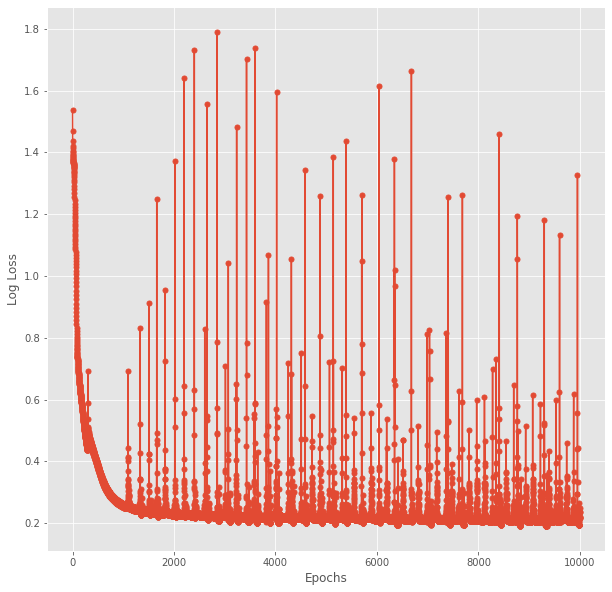

Training Accuary: 0.92
Validation Accuracy: 0.924
Wall time: 27.8 s


In [13]:
%%time
model = FeedForwardNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs = 10000, eta = 1, algo = "GD", display_loss = True)
print_accuracy()

100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 355.73epoch/s]


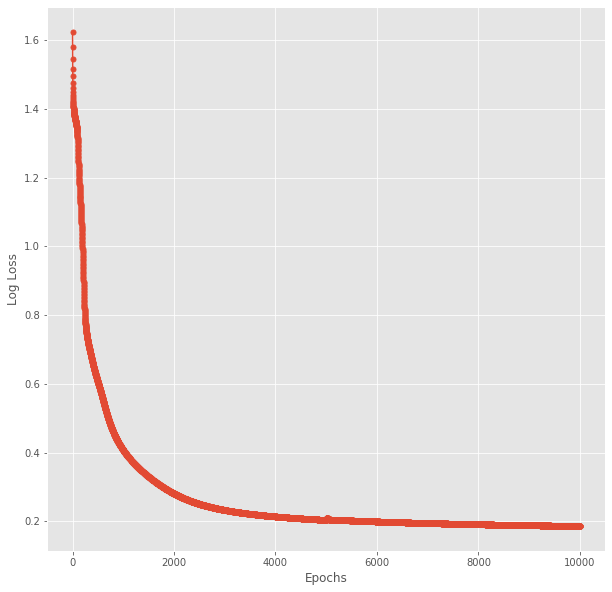

Training Accuary: 0.924
Validation Accuracy: 0.94
Wall time: 28.6 s


In [14]:
%%time
model = FeedForwardNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs = 10000, eta = 1, algo = "MiniBatch",mini_batch_size = 2222, display_loss = True)
print_accuracy()

100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 319.66epoch/s]


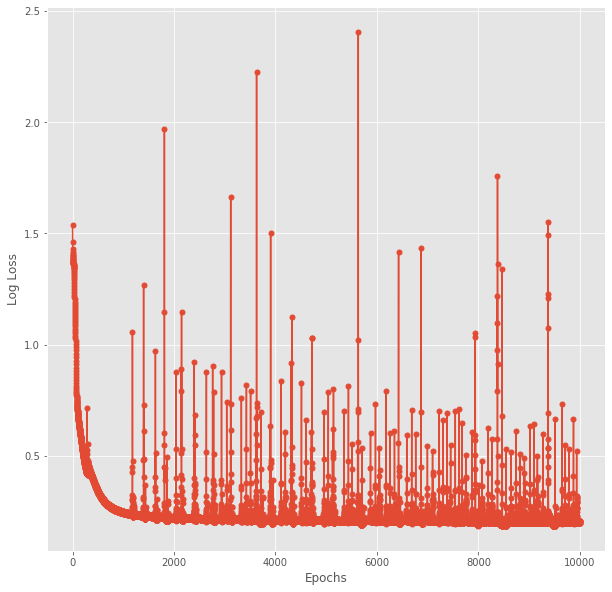

Training Accuary: 0.916
Validation Accuracy: 0.92
Wall time: 31.8 s


In [15]:
%%time
model = FeedForwardNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs = 10000, eta = 1, algo = "MomentumGD",gamma = 0.1, display_loss = True)
print_accuracy()

100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 322.06epoch/s]


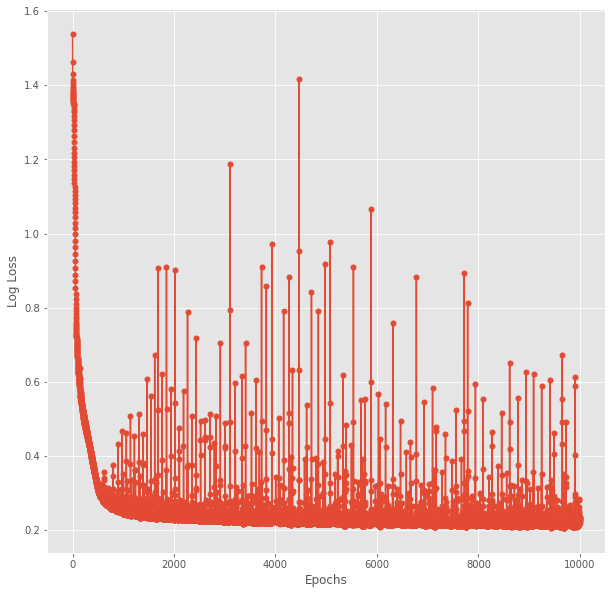

Training Accuary: 0.9093
Validation Accuracy: 0.896
Wall time: 31.7 s


In [16]:
%%time
model = FeedForwardNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs = 10000, eta = 1, algo = "NAG",gamma = 0.5, display_loss = True)
print_accuracy()

100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:36<00:00, 275.58epoch/s]


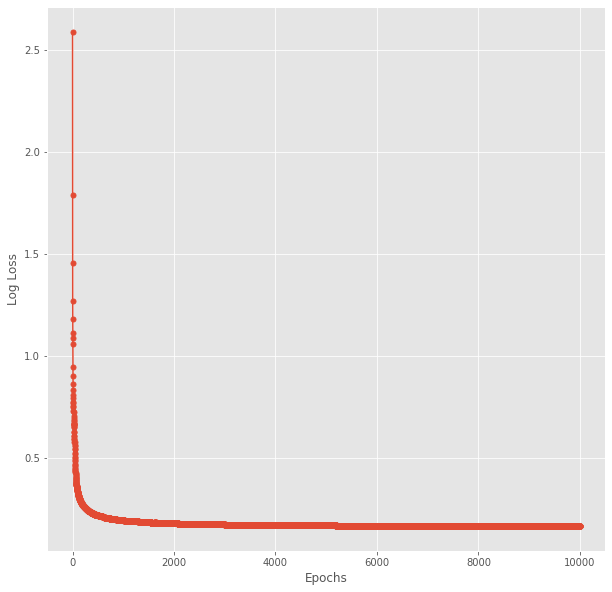

Training Accuary: 0.924
Validation Accuracy: 0.944
Wall time: 36.8 s


In [17]:
%%time
model = FeedForwardNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs = 10000, eta = 1, algo = "AdaGrad",gamma = 0.5, display_loss = True)
print_accuracy()

100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 335.87epoch/s]


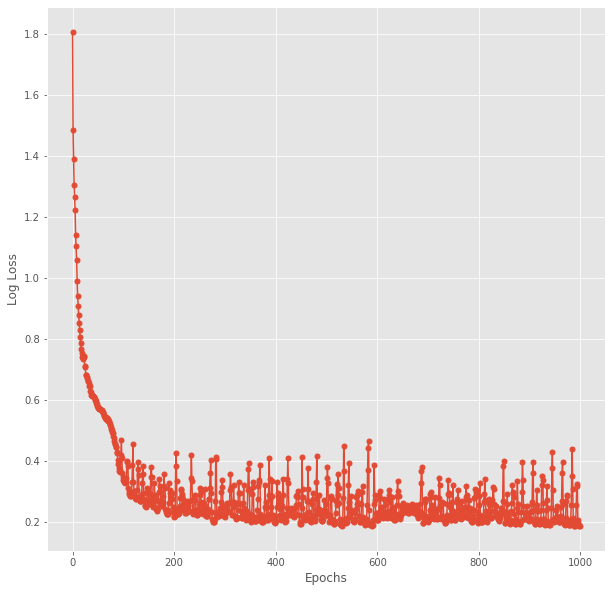

Training Accuary: 0.9253
Validation Accuracy: 0.932
Wall time: 3.57 s


In [27]:
%%time
model = FeedForwardNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs = 1000, eta = .2, algo = "RMSProp", display_loss = True)
print_accuracy()

100%|████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 306.51epoch/s]


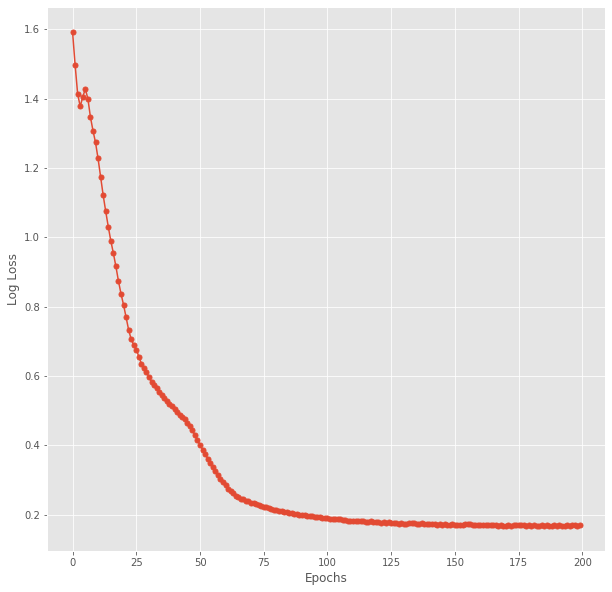

Training Accuary: 0.9293
Validation Accuracy: 0.952
Wall time: 1.13 s


In [21]:
%%time
model = FeedForwardNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs = 200, eta = .1, algo = "Adam",gamma = 0.5, display_loss = True)
print_accuracy()